#A3 CV
##Hamza Ali Imran
##273922

## Cloning the Pre-Processed Data which I have push into my repo



In [0]:
!git clone https://github.com/ibtisam14/preprocessed_dataset.git

fatal: destination path 'preprocessed_dataset' already exists and is not an empty directory.


In [0]:
ls  preprocessed_dataset

test/  train/


In [0]:
ls /content/preprocessed_dataset/train

Cyclone/  Earthquake/  Flood/  Wildfire/


In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
import os
from sklearn.metrics import confusion_matrix, classification_report

from keras.optimizers import Adadelta
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint


learning_rate = 0.1
least_learning_rate = 0.00001  
reduction_by = 0.5  
patience = 3 
verbose = 1  
image_size = (100, 100) 
input_shape = (100, 100, 3) 
use_label_file = False 
label_file = 'labels.txt'
base_dir = '/content/preprocessed_dataset'  
test_dir = os.path.join(base_dir, 'test')
train_dir = os.path.join(base_dir, 'train')
output_dir = 'output_files'  

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

if use_label_file:
    with open(label_file, "r") as f:
        labels = [x.strip() for x in f.readlines()]
else:
    labels = os.listdir(train_dir)
num_classes = len(labels)
print (labels)

Using TensorFlow backend.


['Cyclone', 'Earthquake', 'Flood', 'Wildfire']


In [0]:
# create 2 charts, one for accuracy, one for loss, to show the evolution of these two metrics during the training process
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    # summarize history for accuracy
    axs[0].plot(range(1, len(model_history.history['acc']) + 1), model_history.history['acc'])
    axs[0].plot(range(1, len(model_history.history['val_acc']) + 1), model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history['acc']) + 1), len(model_history.history['acc']))
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']))
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:

# create a confusion matrix to visually represent incorrectly classified images
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])
    plt.figure(figsize=(10, 10))
    ax = sn.heatmap(df_cm, annot=True, square=True, fmt="d", linewidths=.2, cbar_kws={"shrink": 0.8})
    return ax

In [0]:
def build_data_generators(train_folder, test_folder, validation_percent, labels=None, image_size=(100, 100), batch_size=50):
    train_datagen = ImageDataGenerator(
        width_shift_range=0.0,
        height_shift_range=0.0,
        zoom_range=0.0,
        horizontal_flip=True,
        vertical_flip=True, 
        validation_split=validation_percent)

    test_datagen = ImageDataGenerator()

    train_gen = train_datagen.flow_from_directory(train_folder, target_size=image_size, class_mode='sparse', batch_size=batch_size, shuffle=True, subset='training', classes=labels)
    validation_gen = train_datagen.flow_from_directory(train_folder, target_size=image_size, class_mode='sparse', batch_size=batch_size, shuffle=False, subset='validation', classes=labels)
    test_gen = test_datagen.flow_from_directory(test_folder, target_size=image_size, class_mode='sparse', batch_size=batch_size, shuffle=False, subset=None, classes=labels)
    return train_gen, validation_gen, test_gen


In [0]:
def train_and_evaluate_model(model, name="", epochs=35, batch_size=50, verbose=verbose, useCkpt=False):
    model_out_dir = os.path.join(output_dir, name)
    if not os.path.exists(model_out_dir):
        os.makedirs(model_out_dir)
    if useCkpt:
        model.load_weights(model_out_dir + "/model.h5")

    trainGen, validationGen, testGen = build_data_generators(train_dir, test_dir, validation_percent=0.1, labels=labels, image_size=image_size, batch_size=batch_size)
    optimizer = Adadelta(lr=learning_rate)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=patience, verbose=verbose,factor=reduction_by, min_lr=least_learning_rate)
    save_model = ModelCheckpoint(filepath=model_out_dir + "/model.h5", monitor='val_acc', verbose=verbose, save_best_only=True, save_weights_only=False, mode='max', period=1)

    history = model.fit_generator(generator=trainGen,
                                  epochs=epochs,
                                  steps_per_epoch=(trainGen.n // batch_size) + 1,
                                  validation_data=validationGen,
                                  validation_steps=(validationGen.n // batch_size) + 1,
                                  verbose=verbose,
                                  callbacks=[learning_rate_reduction, save_model])

    model.load_weights(model_out_dir + "/model.h5")

    validationGen.reset()
    loss_v, accuracy_v = model.evaluate_generator(validationGen, steps=(validationGen.n // batch_size) + 1, verbose=verbose)
    loss, accuracy = model.evaluate_generator(testGen, steps=(testGen.n // batch_size) + 1, verbose=verbose)
    print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
    print("Test: accuracy = %f  ;  loss_v = %f" % (accuracy, loss))
    plot_model_history(history)
    testGen.reset()
    y_pred = model.predict_generator(testGen, steps=(testGen.n // batch_size) + 1, verbose=verbose)
    y_true = testGen.classes[testGen.index_array]
    plot_confusion_matrix(y_true, y_pred.argmax(axis=-1), labels)
    class_report = classification_report(y_true, y_pred.argmax(axis=-1), target_names=labels)

    with open(model_out_dir + "/classification_report.txt", "w") as text_file:
        text_file.write("%s" % class_report)


## CNN Part Starting from here


Found 2789 images belonging to 4 classes.
Found 308 images belonging to 4 classes.
Found 1332 images belonging to 4 classes.
Epoch 1/35
56/56 [==============================] - 4s 64ms/step - loss: 11.2916 - acc: 0.2799 - val_loss: 10.8232 - val_acc: 0.3214

Epoch 00001: val_acc improved from -inf to 0.32143, saving model to output_files/First attemp model/model.h5
Epoch 2/35
56/56 [==============================] - 2s 40ms/step - loss: 7.5922 - acc: 0.3457 - val_loss: 1.2358 - val_acc: 0.4416

Epoch 00002: val_acc improved from 0.32143 to 0.44156, saving model to output_files/First attemp model/model.h5
Epoch 3/35
56/56 [==============================] - 3s 49ms/step - loss: 1.1195 - acc: 0.5120 - val_loss: 0.9498 - val_acc: 0.6071

Epoch 00003: val_acc improved from 0.44156 to 0.60714, saving model to output_files/First attemp model/model.h5
Epoch 4/35
56/56 [==============================] - 3s 50ms/step - loss: 0.9833 - acc: 0.5825 - val_loss: 1.0376 - val_acc: 0.5584

Epoch 00004:

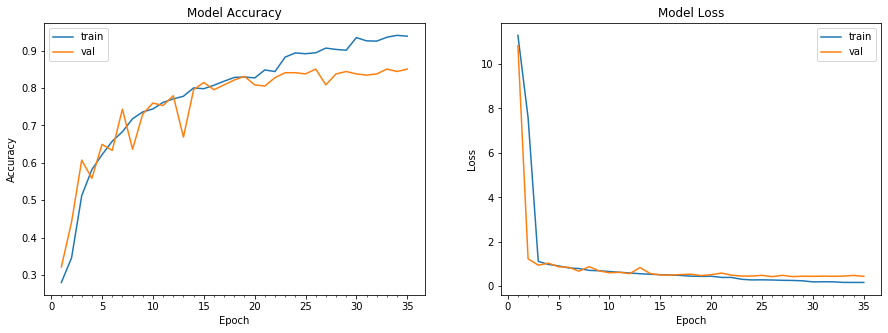

27/27 [==============================] - 1s 43ms/step


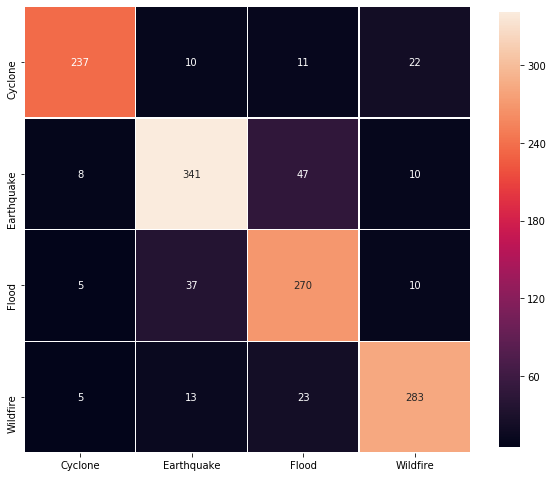

In [0]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout


def network(input_shape, num_classes):
    img_input = Input(shape=input_shape, name='data')
    x = Conv2D(16, (5, 5), strides=(1, 1), padding='same', name='conv1')(img_input)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
    x = Conv2D(32, (5, 5), strides=(1, 1), padding='same', name='conv2')(x)
    x = Activation('relu', name='conv2_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
    x = Conv2D(64, (5, 5), strides=(1, 1), padding='same', name='conv3')(x)
    x = Activation('relu', name='conv3_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool3')(x)
    x = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv4')(x)
    x = Activation('relu', name='conv4_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool4')(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu', name='fcl1')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu', name='fcl2')(x)
    x = Dropout(0.2)(x)
    out = Dense(num_classes, activation='softmax', name='predictions')(x)
    rez = Model(inputs=img_input, outputs=out)
    return rez

model = network(input_shape=input_shape, num_classes=num_classes)
train_and_evaluate_model(model, name="First attemp model")

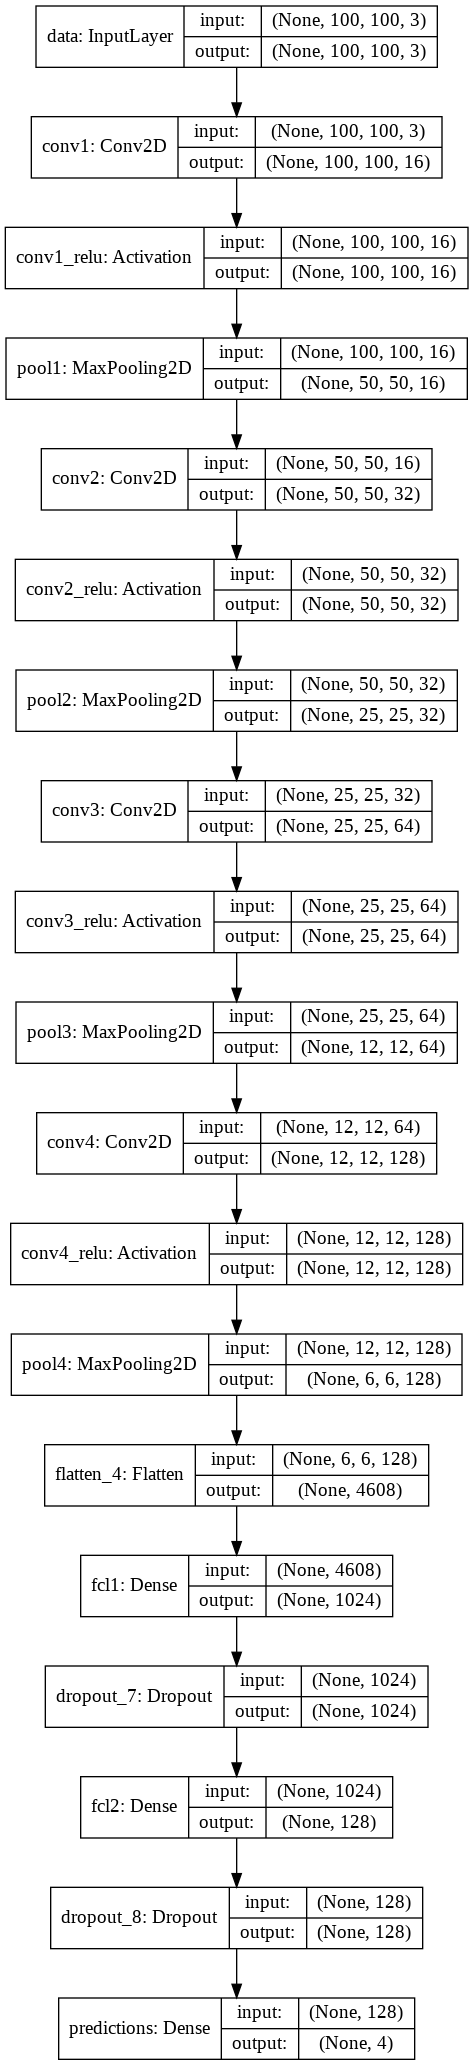

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Found 2789 images belonging to 4 classes.
Found 308 images belonging to 4 classes.
Found 1332 images belonging to 4 classes.
Epoch 1/35
56/56 [==============================] - 4s 77ms/step - loss: 2.3793 - acc: 0.3171 - val_loss: 1.3009 - val_acc: 0.3636

Epoch 00001: val_acc improved from -inf to 0.36364, saving model to output_files/Second attemp model/model.h5
Epoch 2/35
56/56 [==============================] - 2s 45ms/step - loss: 1.3070 - acc: 0.3766 - val_loss: 1.2096 - val_acc: 0.4903

Epoch 00002: val_acc improved from 0.36364 to 0.49026, saving model to output_files/Second attemp model/model.h5
Epoch 3/35
56/56 [==============================] - 3s 55ms/step - loss: 1.2630 - acc: 0.4229 - val_loss: 1.1712 - val_acc: 0.4903

Epoch 00003: val_acc improved from 0.49026 to 0.49026, saving model to output_files/Second attemp model/model.h5
Epoch 4/35
56/56 [==============================] - 3s 55ms/step - loss: 1.2248 - acc: 0.4563 - val_loss: 1.2055 - val_acc: 0.4708

Epoch 00004

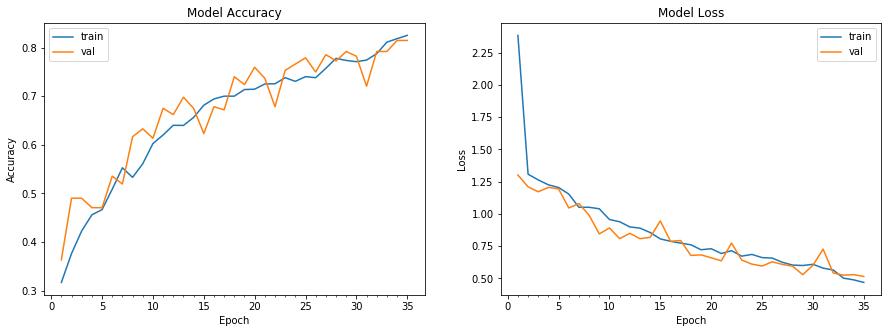

27/27 [==============================] - 1s 45ms/step


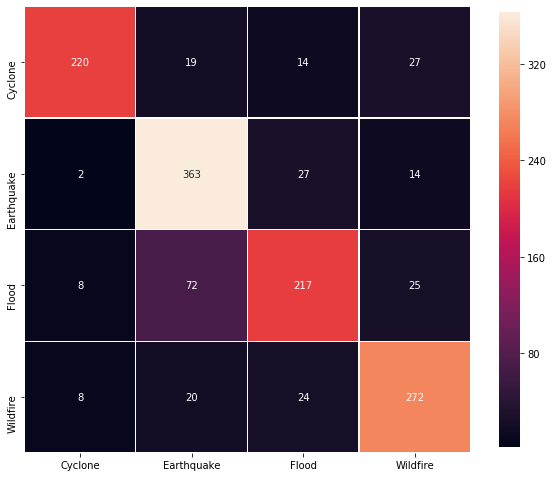

In [0]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout


def network(input_shape, num_classes):
    img_input = Input(shape=input_shape, name='data')
    x = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv1')(img_input)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
    x = Conv2D(64, (5, 5), strides=(1, 1), padding='same', name='conv2')(x)
    x = Activation('relu', name='conv2_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
    x = Conv2D(32, (5, 5), strides=(1, 1), padding='same', name='conv3')(x)
    x = Activation('relu', name='conv3_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool3')(x)
    x = Conv2D(16, (5, 5), strides=(1, 1), padding='same', name='conv4')(x)
    x = Activation('relu', name='conv4_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool4')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu', name='fcl1')(x)
    x = Dropout(0.2)(x)
    out = Dense(num_classes, activation='softmax', name='predictions')(x)
    rez = Model(inputs=img_input, outputs=out)
    return rez


model = network(input_shape=input_shape, num_classes=num_classes)
train_and_evaluate_model(model, name="Second attemp model")

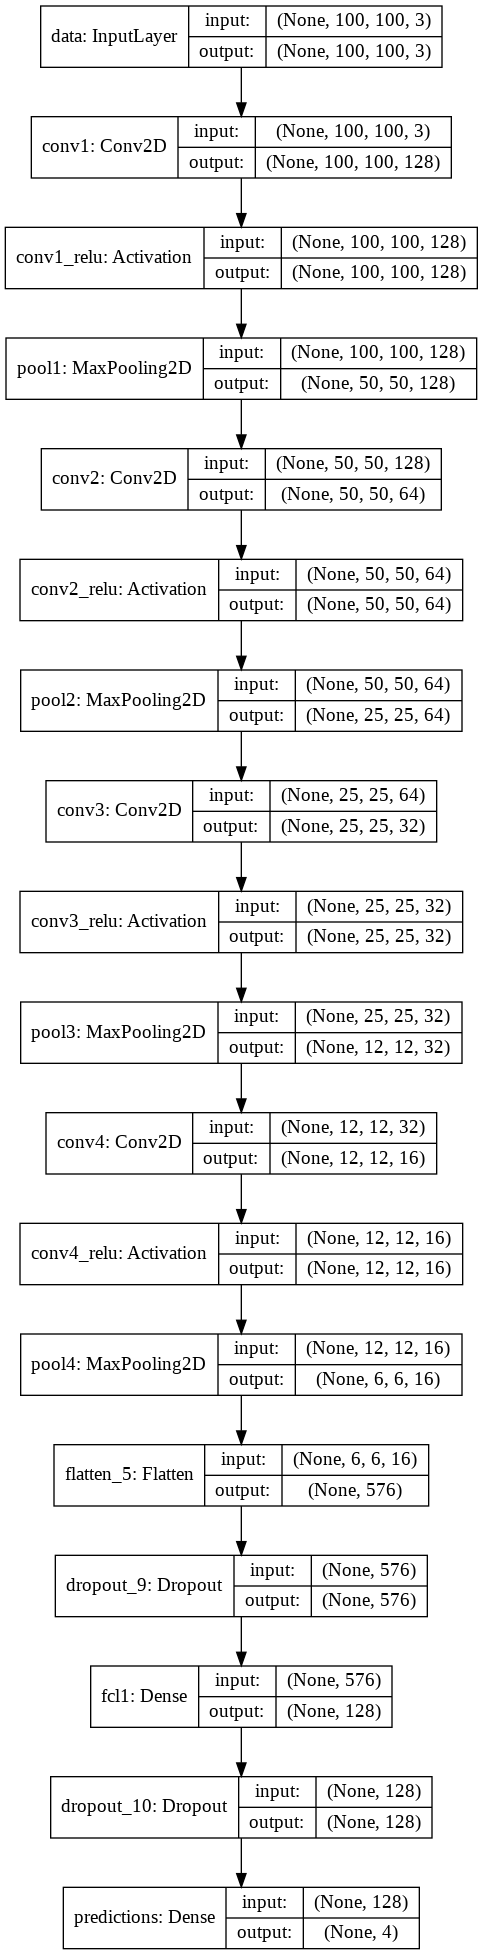

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Found 2789 images belonging to 4 classes.
Found 308 images belonging to 4 classes.
Found 1332 images belonging to 4 classes.
Epoch 1/35
56/56 [==============================] - 4s 74ms/step - loss: 4.7853 - acc: 0.2812 - val_loss: 1.3968 - val_acc: 0.3539

Epoch 00001: val_acc improved from -inf to 0.35390, saving model to output_files/Third attemp model/model.h5
Epoch 2/35
56/56 [==============================] - 2s 43ms/step - loss: 1.4627 - acc: 0.3239 - val_loss: 1.2819 - val_acc: 0.3864

Epoch 00002: val_acc improved from 0.35390 to 0.38636, saving model to output_files/Third attemp model/model.h5
Epoch 3/35
56/56 [==============================] - 3s 52ms/step - loss: 1.3130 - acc: 0.3639 - val_loss: 1.1949 - val_acc: 0.4156

Epoch 00003: val_acc improved from 0.38636 to 0.41558, saving model to output_files/Third attemp model/model.h5
Epoch 4/35
56/56 [==============================] - 3s 53ms/step - loss: 1.2233 - acc: 0.4385 - val_loss: 1.1714 - val_acc: 0.4416

Epoch 00004: v

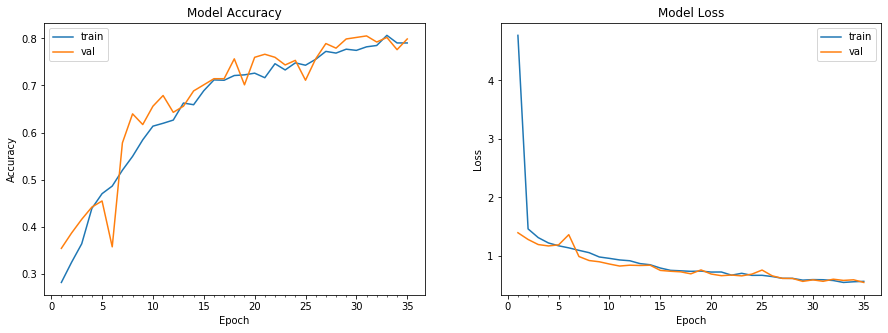

27/27 [==============================] - 1s 45ms/step


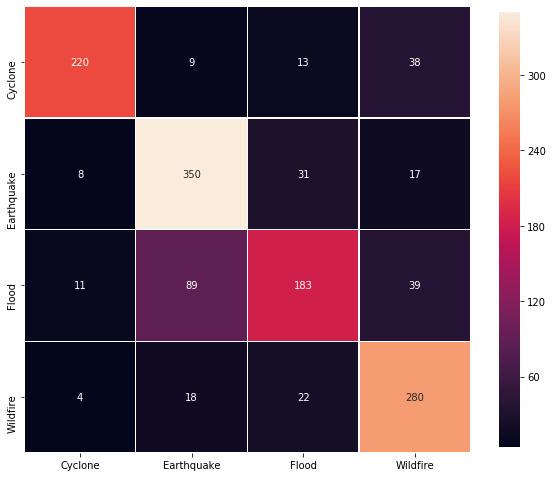

In [0]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout



def network(input_shape, num_classes):
    img_input = Input(shape=input_shape, name='data')
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', name='conv1')(img_input)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pool1')(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', name='conv2')(x)
    x = Activation('relu', name='conv2_relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pool2')(x)
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', name='conv3')(x)
    x = Activation('relu', name='conv3_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool3')(x)
    x = Conv2D(16, (3, 3), strides=(1, 1), padding='same', name='conv4')(x)
    x = Activation('relu', name='conv4_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool4')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu', name='fcl1')(x)
    x = Dropout(0.2)(x)
    out = Dense(num_classes, activation='softmax', name='predictions')(x)
    rez = Model(inputs=img_input, outputs=out)
    return rez


model = network(input_shape=input_shape, num_classes=num_classes)
train_and_evaluate_model(model, name="Third attemp model")

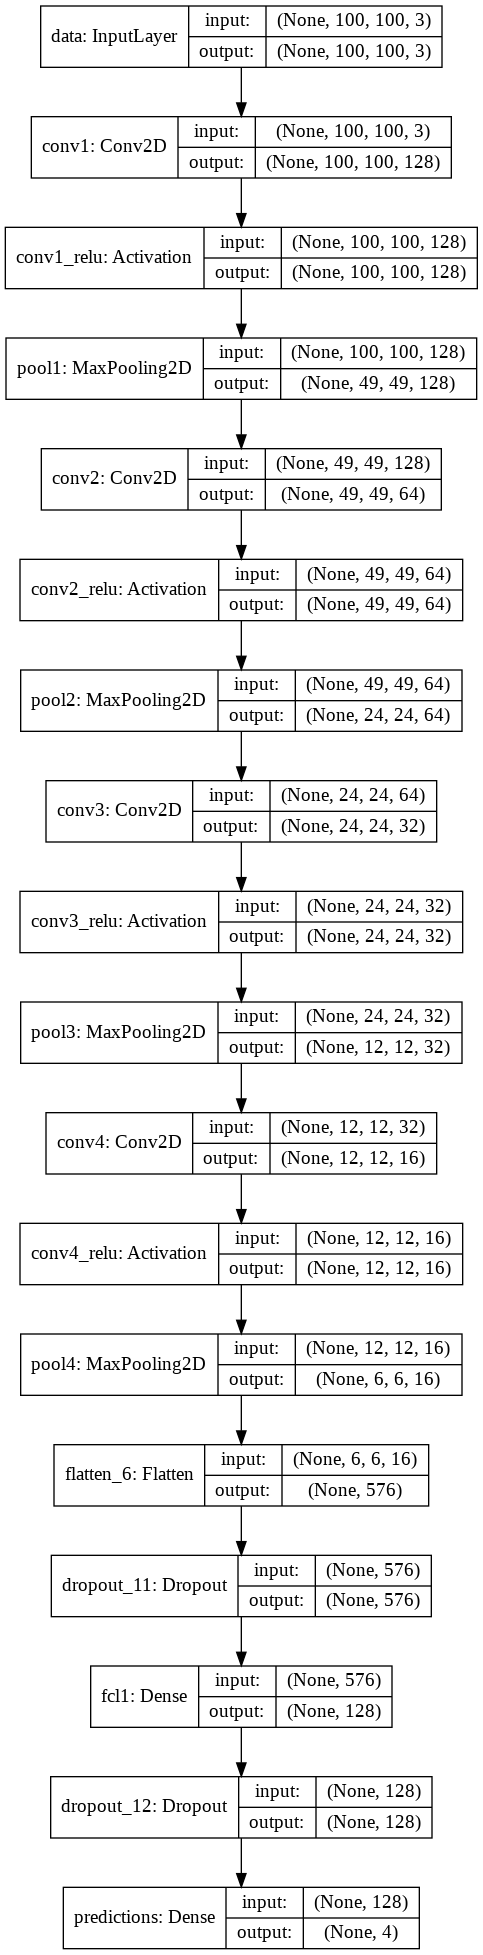

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Found 2789 images belonging to 4 classes.
Found 308 images belonging to 4 classes.
Found 1332 images belonging to 4 classes.
Epoch 1/35
56/56 [==============================] - 4s 76ms/step - loss: 3.5704 - acc: 0.3257 - val_loss: 1.2274 - val_acc: 0.4318

Epoch 00001: val_acc improved from -inf to 0.43182, saving model to output_files/4th attemp model/model.h5
Epoch 2/35
56/56 [==============================] - 2s 41ms/step - loss: 1.3121 - acc: 0.3950 - val_loss: 1.1162 - val_acc: 0.5584

Epoch 00002: val_acc improved from 0.43182 to 0.55844, saving model to output_files/4th attemp model/model.h5
Epoch 3/35
56/56 [==============================] - 3s 51ms/step - loss: 1.1861 - acc: 0.4704 - val_loss: 1.0427 - val_acc: 0.5552

Epoch 00003: val_acc did not improve from 0.55844
Epoch 4/35
56/56 [==============================] - 3s 50ms/step - loss: 1.1537 - acc: 0.4886 - val_loss: 0.9669 - val_acc: 0.6299

Epoch 00004: val_acc improved from 0.55844 to 0.62987, saving model to output_fi

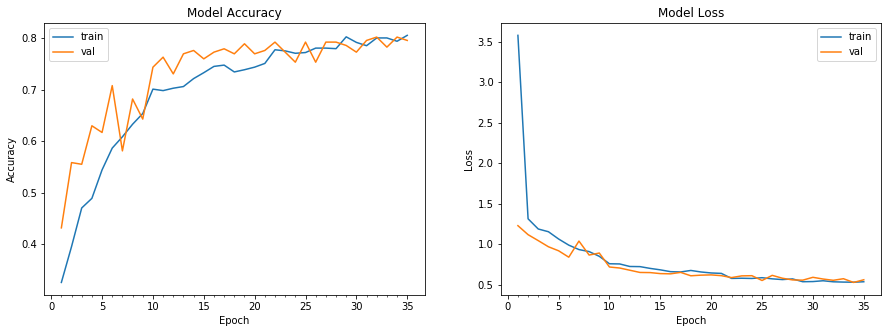

27/27 [==============================] - 1s 45ms/step


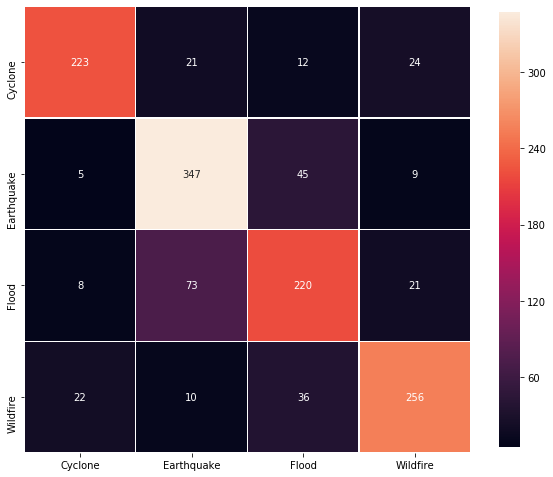

In [0]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout


def network(input_shape, num_classes):
    img_input = Input(shape=input_shape, name='data')
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', name='conv1')(img_input)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', name='conv2')(x)
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', name='conv3')(x)
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', name='conv4')(x)
    x = Activation('relu', name='conv2_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', name='conv5')(x)
    x = Activation('relu', name='conv3_relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pool5')(x)
    x = Conv2D(16, (3, 3), strides=(1, 1), padding='same', name='conv6')(x)
    x = Activation('relu', name='conv4_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool6')(x)
    x = Flatten()(x)
    x = Dropout(0.25)(x)
    x = Dense(512, activation='relu', name='fcl1')(x)
    x = Dropout(0.25)(x)
    out = Dense(num_classes, activation='softmax', name='predictions')(x)
    rez = Model(inputs=img_input, outputs=out)
    return rez


model = network(input_shape=input_shape, num_classes=num_classes)
train_and_evaluate_model(model, name="4th attemp model")

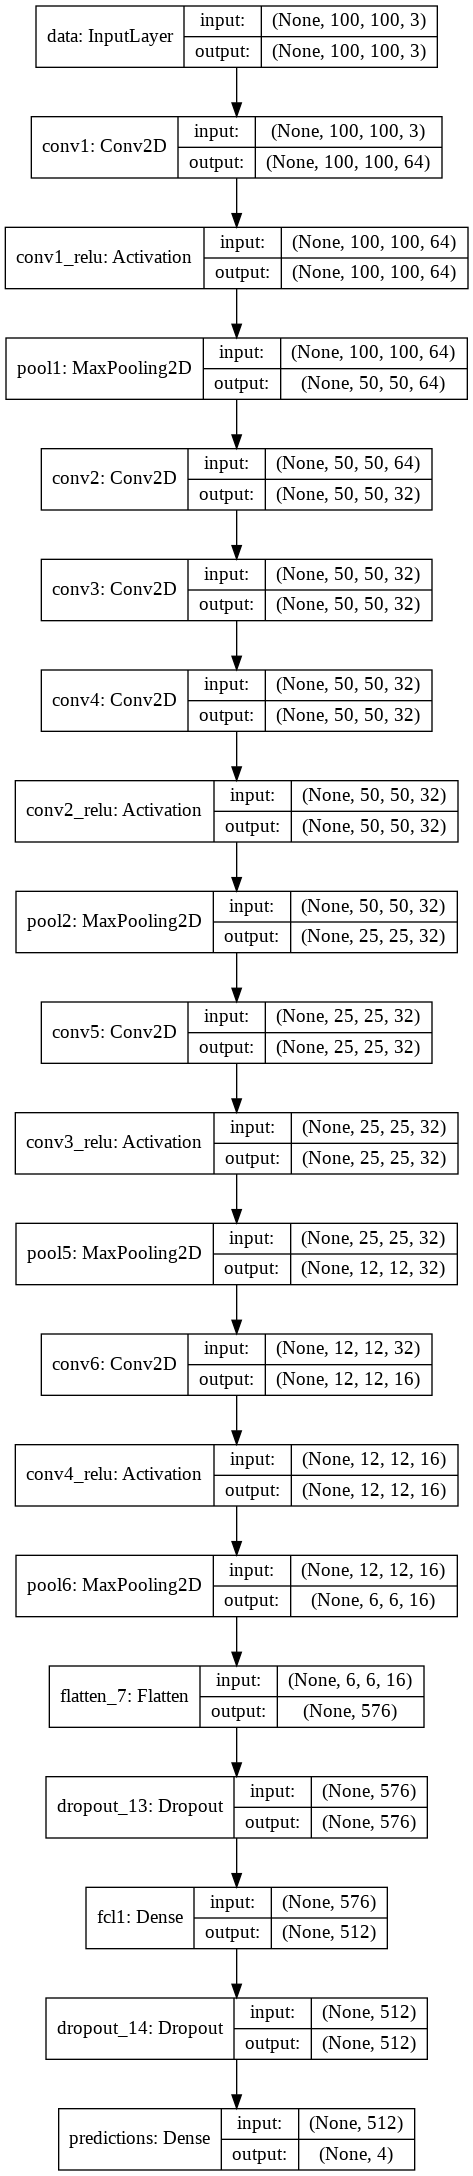

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Found 2789 images belonging to 4 classes.
Found 308 images belonging to 4 classes.
Found 1332 images belonging to 4 classes.
Epoch 1/35
56/56 [==============================] - 5s 90ms/step - loss: 6.8932 - acc: 0.3048 - val_loss: 1.3184 - val_acc: 0.4188

Epoch 00001: val_acc improved from -inf to 0.41883, saving model to output_files/5th attemp model/model.h5
Epoch 2/35
56/56 [==============================] - 3s 48ms/step - loss: 1.2603 - acc: 0.4330 - val_loss: 1.0434 - val_acc: 0.5552

Epoch 00002: val_acc improved from 0.41883 to 0.55519, saving model to output_files/5th attemp model/model.h5
Epoch 3/35
56/56 [==============================] - 3s 57ms/step - loss: 0.9943 - acc: 0.5855 - val_loss: 0.9001 - val_acc: 0.6526

Epoch 00003: val_acc improved from 0.55519 to 0.65260, saving model to output_files/5th attemp model/model.h5
Epoch 4/35
56/56 [==============================] - 3s 56ms/step - loss: 0.8714 - acc: 0.6468 - val_loss: 0.8946 - val_acc: 0.6818

Epoch 00004: val_acc

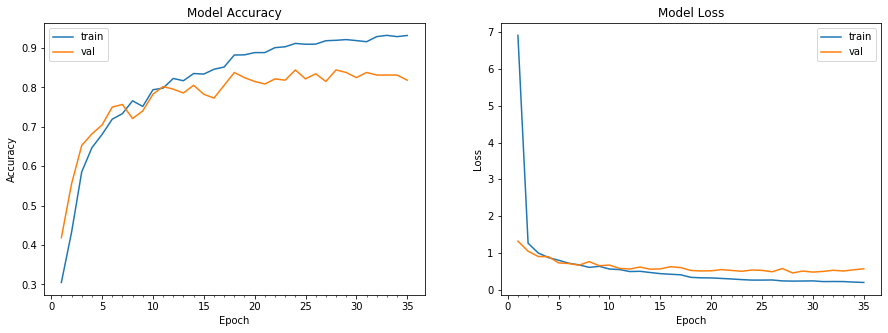

27/27 [==============================] - 1s 49ms/step


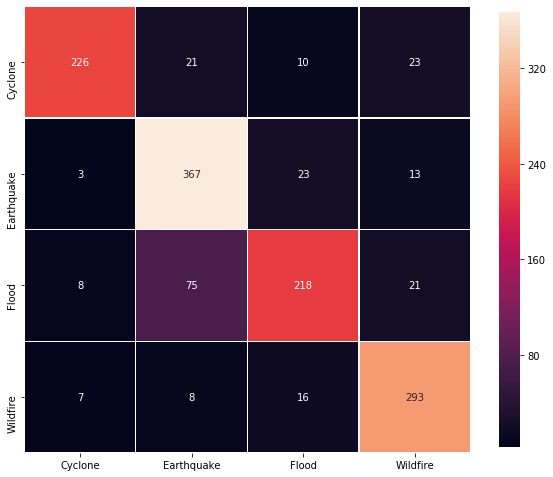

In [0]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout


def network(input_shape, num_classes):
    img_input = Input(shape=input_shape, name='data')
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', name='conv1')(img_input)
    x = Activation('relu', name='conv1_relu')(x)
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', name='conv2')(x)
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', name='conv3')(x)
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', name='conv4')(x)
    x = Activation('relu', name='conv2_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', name='conv5')(x)
    x = Activation('relu', name='conv3_relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pool5')(x)
    x = Conv2D(16, (3, 3), strides=(1, 1), padding='same', name='conv8')(x)
    x = Activation('relu', name='conv4_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool6')(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu', name='fcl1')(x)
    x = Dropout(0.25)(x)
    out = Dense(num_classes, activation='softmax', name='predictions')(x)
    rez = Model(inputs=img_input, outputs=out)
    return rez


model = network(input_shape=input_shape, num_classes=num_classes)
train_and_evaluate_model(model, name="5th attemp model")

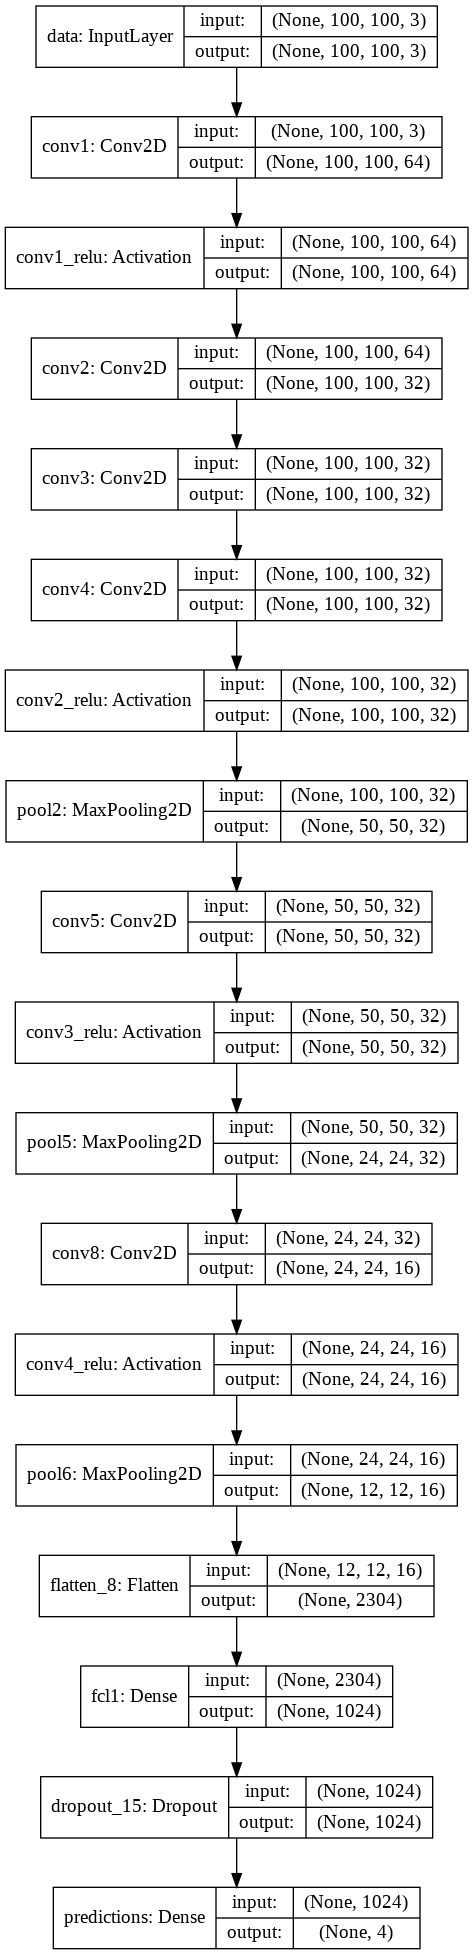

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Found 2789 images belonging to 4 classes.
Found 308 images belonging to 4 classes.
Found 1332 images belonging to 4 classes.
Epoch 1/35
56/56 [==============================] - 5s 81ms/step - loss: 6.0627 - acc: 0.3562 - val_loss: 1.0468 - val_acc: 0.5844

Epoch 00001: val_acc improved from -inf to 0.58442, saving model to output_files/6th attemp model/model.h5
Epoch 2/35
56/56 [==============================] - 2s 43ms/step - loss: 1.1522 - acc: 0.5034 - val_loss: 0.9530 - val_acc: 0.6039

Epoch 00002: val_acc improved from 0.58442 to 0.60390, saving model to output_files/6th attemp model/model.h5
Epoch 3/35
56/56 [==============================] - 3s 51ms/step - loss: 1.0404 - acc: 0.5546 - val_loss: 0.9219 - val_acc: 0.6201

Epoch 00003: val_acc improved from 0.60390 to 0.62013, saving model to output_files/6th attemp model/model.h5
Epoch 4/35
56/56 [==============================] - 3s 52ms/step - loss: 0.9345 - acc: 0.6245 - val_loss: 0.9832 - val_acc: 0.5974

Epoch 00004: val_acc

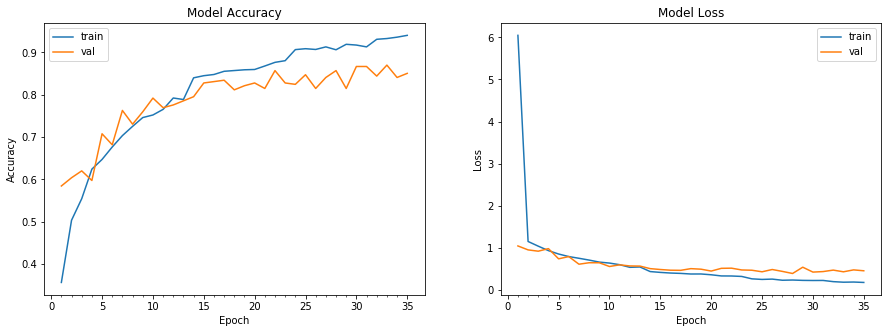

27/27 [==============================] - 1s 51ms/step


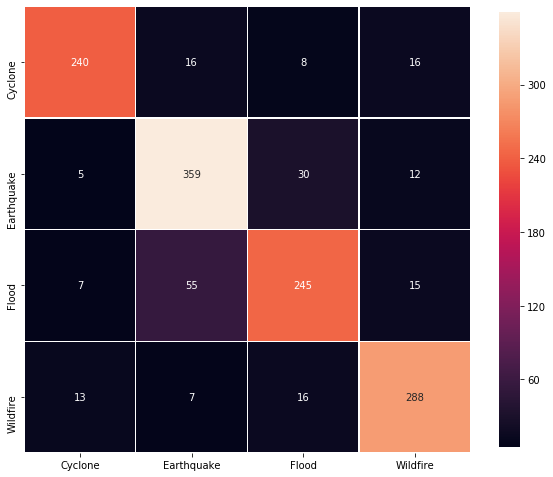

In [0]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout
from keras.layers import Lambda

def channal_increase(img):
    import tensorflow as tf
    hsv = tf.image.rgb_to_hsv(img)
    gray = tf.image.rgb_to_grayscale(img)
    yiq=tf.image.rgb_to_yiq(img)
    ext = tf.concat([hsv, gray,yiq], axis=-1)
    return ext

def network(input_shape, num_classes):
    img_input = Input(shape=input_shape, name='data')
    x = Lambda(channal_increase)(img_input)
    x = Conv2D(16, (5, 5), strides=(1, 1), padding='same', name='conv1')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
    x = Conv2D(32, (5, 5), strides=(1, 1), padding='same', name='conv2')(x)
    x = Activation('relu', name='conv2_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
    x = Conv2D(64, (5, 5), strides=(1, 1), padding='same', name='conv3')(x)
    x = Activation('relu', name='conv3_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool3')(x)
    x = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv4')(x)
    x = Activation('relu', name='conv4_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool4')(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu', name='fcl1')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu', name='fcl2')(x)
    x = Dropout(0.2)(x)
    out = Dense(num_classes, activation='softmax', name='predictions')(x)
    result = Model(inputs=img_input, outputs=out)
    return result


model = network(input_shape=input_shape, num_classes=num_classes)
train_and_evaluate_model(model, name="6th attemp model")

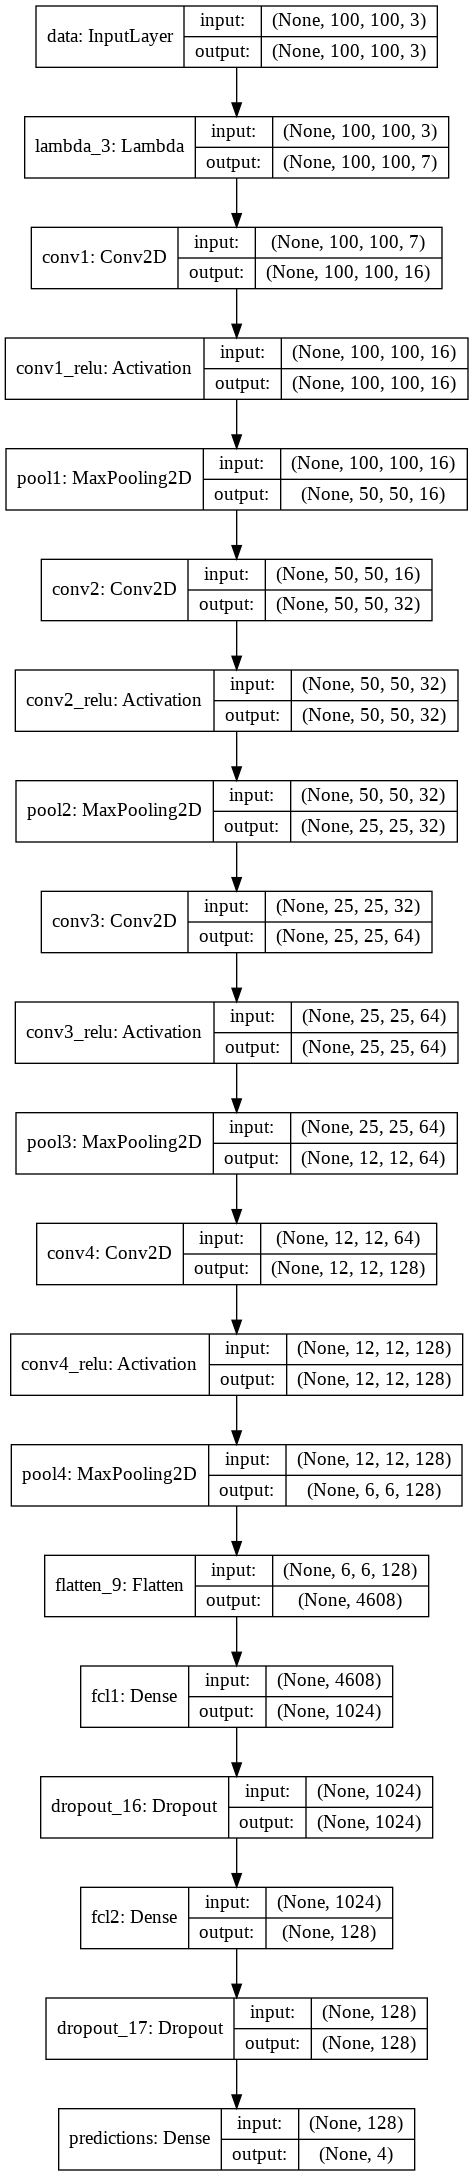

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Found 2789 images belonging to 4 classes.
Found 308 images belonging to 4 classes.
Found 1332 images belonging to 4 classes.
Epoch 1/35
56/56 [==============================] - 5s 85ms/step - loss: 1.2555 - acc: 0.4339 - val_loss: 0.9673 - val_acc: 0.6104

Epoch 00001: val_acc improved from -inf to 0.61039, saving model to output_files/7th attemp model/model.h5
Epoch 2/35
56/56 [==============================] - 2s 40ms/step - loss: 0.9892 - acc: 0.5863 - val_loss: 1.0133 - val_acc: 0.6104

Epoch 00002: val_acc improved from 0.61039 to 0.61039, saving model to output_files/7th attemp model/model.h5
Epoch 3/35
56/56 [==============================] - 3s 50ms/step - loss: 0.8658 - acc: 0.6549 - val_loss: 0.8091 - val_acc: 0.6916

Epoch 00003: val_acc improved from 0.61039 to 0.69156, saving model to output_files/7th attemp model/model.h5
Epoch 4/35
56/56 [==============================] - 3s 49ms/step - loss: 0.8212 - acc: 0.6734 - val_loss: 0.7932 - val_acc: 0.6981

Epoch 00004: val_acc

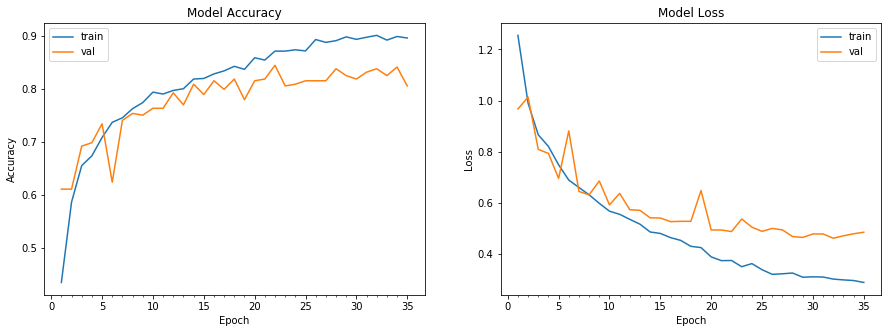

27/27 [==============================] - 1s 52ms/step


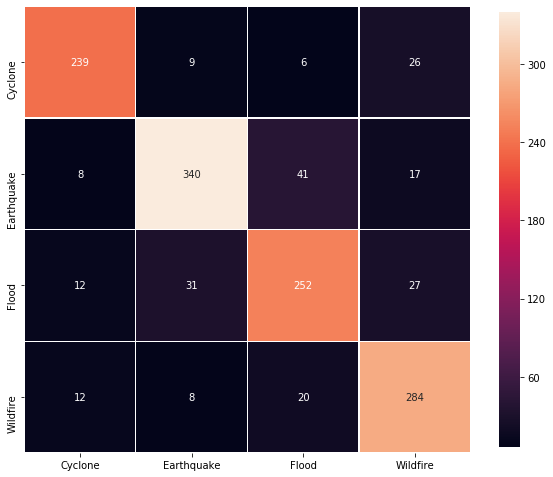

In [0]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout
from keras.layers import Lambda

def channal_increase2(img):
    import tensorflow as tf
    hsv = tf.image.rgb_to_hsv(img)
    gray = tf.image.rgb_to_grayscale(img)
    yiq=tf.image.rgb_to_yiq(img)
    ext = tf.concat([hsv, gray,yiq], axis=-1)
    return ext

def network(input_shape, num_classes):
    img_input = Input(shape=input_shape, name='data')
    x = Lambda(channal_increase2)(img_input)
    x = Conv2D(16, (3, 3), strides=(1, 1), padding='same', name='conv1')(x)
    x = Activation('tanh', name='conv1_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', name='conv2')(x)
    x = Activation('tanh', name='conv2_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', name='conv3')(x)
    x = Activation('tanh', name='conv3_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool3')(x)
    x = Conv2D(128, (3,3), strides=(1, 1), padding='same', name='conv4')(x)
    x = Activation('tanh', name='conv4_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool4')(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu', name='fcl1')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu', name='fcl2')(x)
    x = Dropout(0.2)(x)
    out = Dense(num_classes, activation='softmax', name='predictions')(x)
    result = Model(inputs=img_input, outputs=out)
    return result


model = network(input_shape=input_shape, num_classes=num_classes)
train_and_evaluate_model(model, name="7th attemp model")

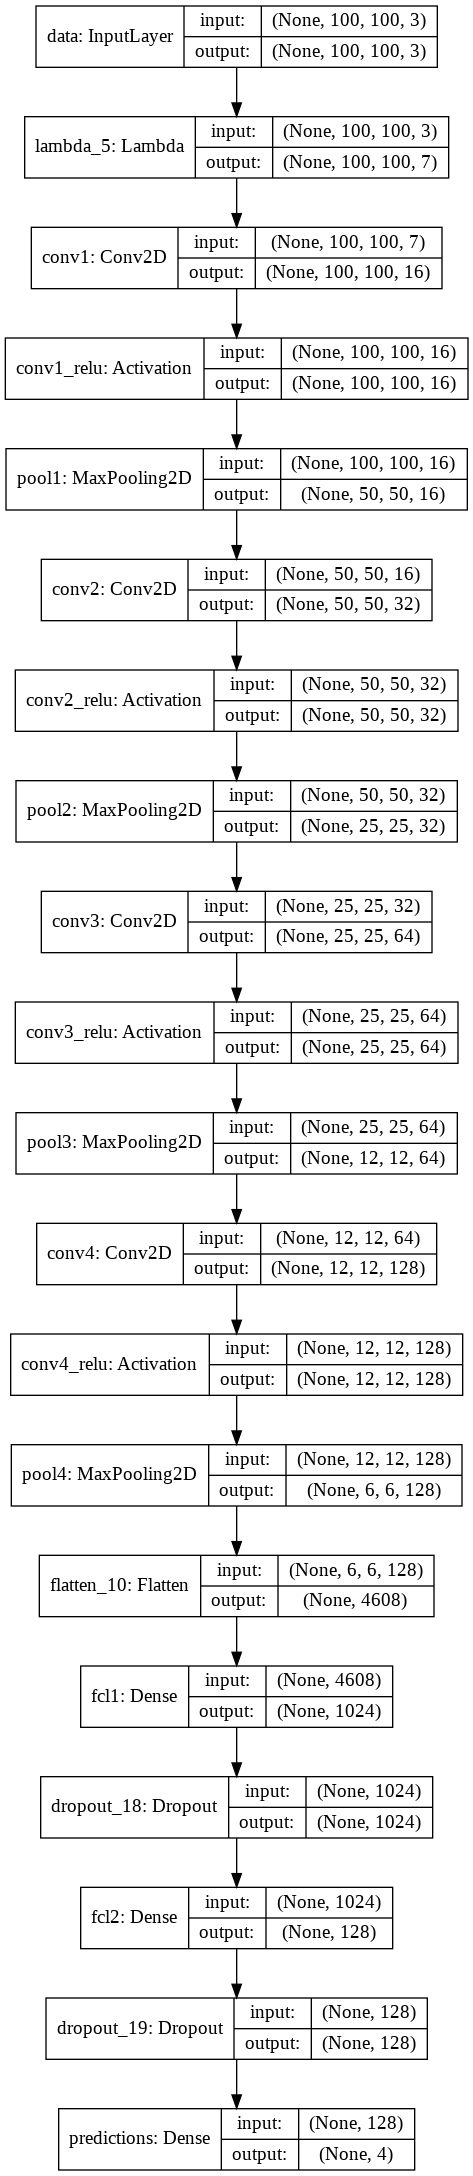

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)